# Basic repeating API for scatter plots

## Required features

Some of these require upstream changes

- [ ] Use same legend for repeated features
- [ ] Use same color scale for repeated features
- [ ] Share axis labels
- [ ] More reasonable masking


In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
from typing import Tuple, Optional

In [10]:
%load_ext blackcellmagic
%load_ext snakeviz

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [3]:
class ScatterGrid(object):
    def __init__(self, **base_kwargs):
        self.col_kwargs: list[dict]
        self.col_kwargs = []
        self.row_kwargs: list[dict]
        self.row_kwargs = []
        self.base_kwargs = base_kwargs

    @property
    def shape(self):
        return max(len(self.row_kwargs), 1), max(len(self.col_kwargs), 1)

    @property
    def cols(self):
        return ScatterGridAxes(self.col_kwargs)

    @property
    def rows(self):
        return ScatterGridAxes(self.row_kwargs)

    def plot(self, adata):
        fig = plt.figure(constrained_layout=True)
        gs = fig.add_gridspec(*self.shape)
        for row, col in product(*map(range, self.shape)):
            ax = fig.add_subplot(gs[row, col])
            args = dict(
                **self.base_kwargs,
                **self.row_kwargs[row],
                **self.col_kwargs[col],
                show=False,
                ax=ax,
            )
            self.plot_single(adata, **args)
        return fig

    def plot_single(
        self,
        adata: sc.AnnData,
        *,
        ax: plt.Axes,
        basis: str,
        groups: Optional[Tuple[str, pd.Categorical]] = None,
        **kwargs,
    ):
        if groups is not None:
            mask = adata.obs[groups[0]] == groups[1]
            sc.pl.embedding(
                adata,
                basis=basis,
                ax=ax,
                show=False,
            )
            sc.pl.embedding(
                adata[mask, :],
                basis=basis,
                ax=ax,
                **kwargs
            )
        else:
            sc.pl.embedding(
                adata,
                basis=basis,
                ax=ax,
                **kwargs
            )

In [ ]:
class RepeatAxis(object):
    pass

class FacetAxis(object):
    pass

In [4]:
class ScatterGridAxes(object):
    def __init__(self, kwarg_list):
        self.kwarg_list = kwarg_list

    def add_entry(self, **kwargs):
        self.kwarg_list.append(kwargs)

    def facet_by_group(self, group_key, groups=None, **kwargs):
        for g in groups:
            self.add_entry(groups=(group_key, g), **kwargs)

    def get_color(self):
        return [k.get("color", None) for k in self.kwarg_list]

In [5]:
plt.rcParams["figure.figsize"]

[6.0, 4.0]

In [7]:
pbmc = sc.datasets.pbmc3k_processed().raw.to_adata()

In [8]:
genes = list(pbmc.uns["rank_genes_groups"]["names"][0])[:2]

In [13]:
s = ScatterGrid(basis="umap", s=20, legend_loc=None)
s.cols.facet_by_group("louvain", pbmc.obs["louvain"].cat.categories)
for g in genes:
    s.rows.add_entry(color=g)

In [16]:
?sc.pl.embedding

/Users/isaac/github/anndata/anndata/_core/anndata.py:1116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()


CPU times: user 784 ms, sys: 12.7 ms, total: 797 ms
Wall time: 796 ms


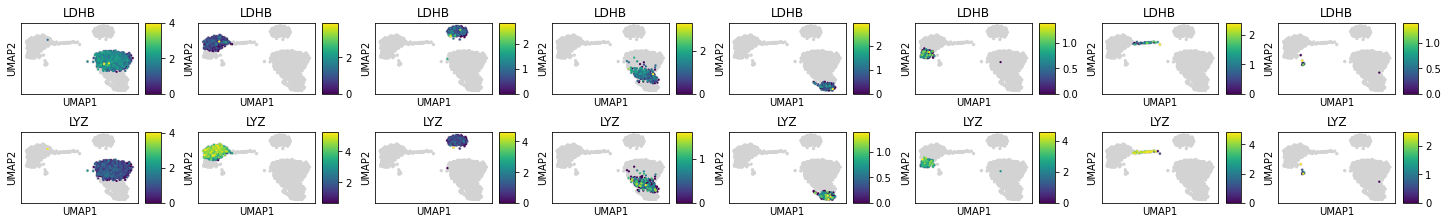

In [15]:
with plt.rc_context({"figure.figsize": (20, 3)}):
    s.plot(pbmc);

In [81]:
?%%prun

/Users/isaac/github/anndata/anndata/_core/anndata.py:1116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()


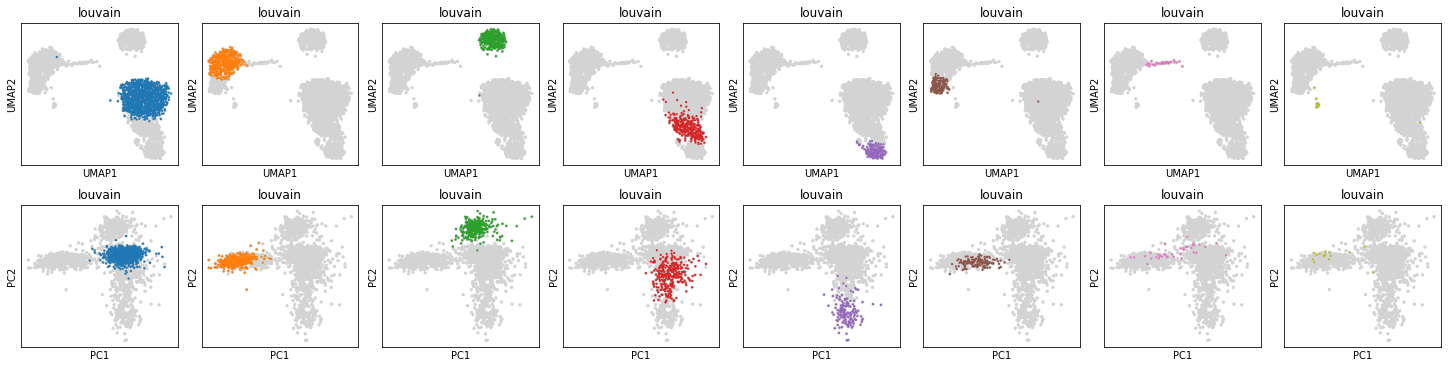

In [17]:
s = ScatterGrid(legend_loc=None, s=20)  # Have to set size or it'll vary by cluster
s.rows.add_entry(basis="umap")
s.rows.add_entry(basis="pca")
s.cols.facet_by_group("louvain", pbmc.obs["louvain"].cat.categories, color="louvain")

with plt.rc_context({"figure.figsize": (20, 5)}):
    s.plot(pbmc);

In [18]:
pbmc.obs["louvain"].cat.categories

Index(['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
       'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes'],
      dtype='object')

In [26]:
new = pbmc[pbmc.obs["louvain"] == "B cells"].copy()

/Users/isaac/github/anndata/anndata/_core/anndata.py:1116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub[k] = df_sub[k].cat.remove_unused_categories()
